# **Generative Models - Part 1: GAN on Frey Dataset**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
mpl.rc('image', cmap='gray')
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import get_file
from scipy.io import loadmat

## 1. Data Loading and Preprocessing

In [2]:
# Function to load and preprocess Frey dataset
# Adapted from frey_diffusion_example.py
def get_frey_data():
    """Loads and preprocesses the Frey dataset.

    Returns:
        numpy.ndarray: Frey face images, normalized to [-1, 1]
                       with shape (N, 28, 20, 1).
    """
    try:
        path = get_file('frey_rawface.mat',
                        'https://www.dropbox.com/scl/fi/m70sh4ef39pvy01czc63r/frey_rawface.mat?rlkey=5v6meiap55z68ada2roxwxuql&dl=1',
                        cache_subdir='datasets') # Added cache_subdir for better organization
        data = np.transpose(loadmat(path)['ff'])  # Shape (1965, 560)
        # Reshape to (num_images, height, width, channels)
        x_train = np.reshape(data, (-1, 28, 20, 1))
        x_train = x_train.astype('float32')
        x_train /= 255.0  # Normalize to [0, 1]
        x_train = (x_train * 2.0) - 1.0  # Normalize to [-1, 1]
        return x_train
    except Exception as e:
        print(f"Error loading Frey dataset: {e}")
        print("Please ensure you have an internet connection and scipy is installed.")
        print("Alternatively, download 'frey_rawface.mat' manually and place it in '~/.keras/datasets/'.")
        return None

Loaded Frey dataset: (1965, 28, 20, 1)
Example images from Frey dataset:


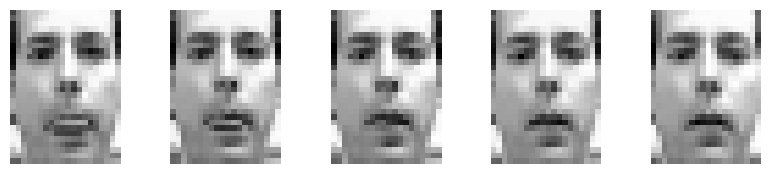

In [4]:
# Load the data
x_train = get_frey_data()

IMG_H, IMG_W, IMG_C = x_train.shape[1:] # Should be 28, 20, 1
print(f"Loaded Frey dataset: {x_train.shape}")

# Display a few example images
print("Example images from Frey dataset:")
plt.figure(figsize=(10, 2))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    # De-normalize for display: from [-1, 1] to [0, 1]
    img_display = (x_train[i] + 1.0) / 2.0
    plt.imshow(np.squeeze(img_display))
    plt.axis('off')
plt.show()

## 1.1: Build the model

### Generator Network
The generator network takes a latent vector and outputs a 28x20x1 image.
- Input: latent vector
- Dense layer: 7\*5\*128 outputs, LeakyReLU(alpha=0.1)
- Reshape: (7,5,128)
- Conv2DTranspose 1: 256 filters, stride 2, padding 'same', LeakyReLU(alpha=0.1) -> (14,10,256)
- Conv2DTranspose 2: 1 filter (output channel), stride 2, padding 'same', no activation (linear) -> (28,20,1)

In [5]:
def build_generator(latent_dim):
    inputs = Input((latent_dim,), name='generator_input')

    # Dense layer: 7*5*128 outputs
    x = Dense(7*5*128, activation=None)(inputs)
    x = LeakyReLU(alpha=0.1)(x)

    # Reshape to (7,5,128)
    x = Reshape((7,5,128))(x)

    # Conv2DTranspose 1: stride 2, 256 filters -> (14,10,256)
    x = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(x) # Default kernel size 3 is common
    x = LeakyReLU(alpha=0.1)(x)

    # Conv2DTranspose 2: stride 2, 1 output channel -> (28,20,1)
    # Output layer, typically tanh for [-1,1] data, or linear as per MNIST example
    output = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation=None)(x)

    return Model(inputs=inputs, outputs=output, name='generator')

### Discriminator Network
The discriminator network takes a 28x20x1 image and outputs a probability.
- Input: 28x20x1 image
- Conv2D 1: 256 filters, stride 2, padding 'same', ReLU activation
- Conv2D 2: 128 filters, stride 2, padding 'same', ReLU activation
- Flatten
- Dense: 1 output, sigmoid activation

In [6]:
# Discriminator model definition
def build_discriminator(img_shape):
    inputs = Input(img_shape, name='discriminator_input')

    # Conv2D 1: 256 channels, stride 2, ReLU
    x = Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu')(inputs) # Default kernel size 3

    # Conv2D 2: 128 channels, stride 2, ReLU
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    # Flatten
    x = Flatten()(x)

    # Dense output layer: 1 output, sigmoid
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=output, name='discriminator')

### Model Instantiation and Summaries

In [7]:

latent_dim = 100

generator = build_generator(latent_dim)
discriminator = build_discriminator((IMG_H, IMG_W, IMG_C))

print("\nGenerator Summary:")
generator.summary()
print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:


/Users/bshowell/Desktop/school/spring 24-25/587/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_input (InputLayer)    │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4480)           │       452,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 10, 256)    │       295,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 20, 1)      │         2,305 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 749,953 (2.86 MB)

 Trainable params: 749,953 (2.86 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Summary:


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_input             │ (None, 28, 20, 1)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 10, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 5, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,081 (1.15 MB)

 Trainable params: 302,081 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

## GAN Training
We set up optimizers and a custom training loop.

In [8]:
# Using Adam optimizer as in the MNIST GAN example
# Learning rates from the example for consistency
g_opt = Adam(learning_rate=3e-4)
d_opt = Adam(learning_rate=3e-4)

num_iter = 5000
batch_size = 32

gen_loss_history = []
discrim_loss_history = []

# Fixed set of random latent vectors to inspect generator's progress
num_samples_to_show = 5
latent_vectors_for_viz = np.random.uniform(-1, 1, size=(num_samples_to_show, latent_dim))

# Binary crossentropy loss function
loss_fn = tf.keras.losses.binary_crossentropy

print(f"\nStarting training for {num_iter} iterations with batch size {batch_size}...")


Starting training for 5000 iterations with batch size 32...


Iter 100/5000: Discriminator Loss: 0.0571, Generator Loss: 2.6924


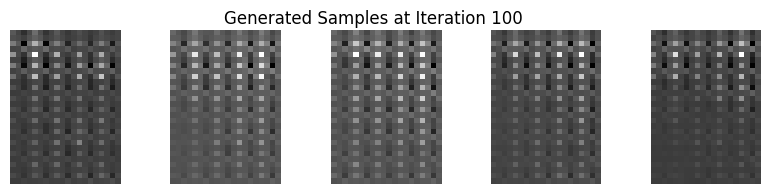

Iter 200/5000: Discriminator Loss: 0.2060, Generator Loss: 3.8347


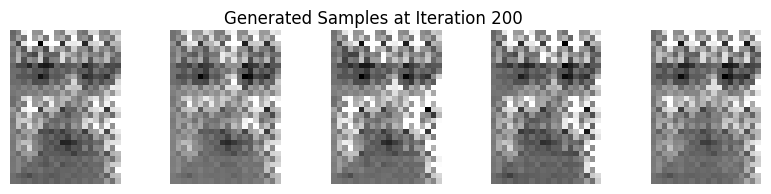

Iter 300/5000: Discriminator Loss: 0.1115, Generator Loss: 3.9994


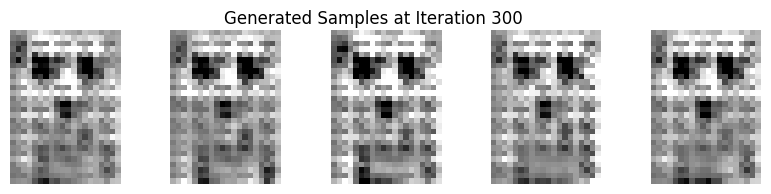

Iter 400/5000: Discriminator Loss: 0.1690, Generator Loss: 3.1365


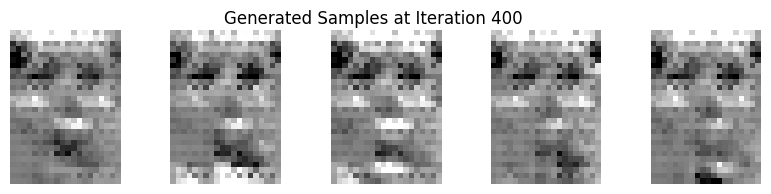

Iter 500/5000: Discriminator Loss: 0.1943, Generator Loss: 2.3178


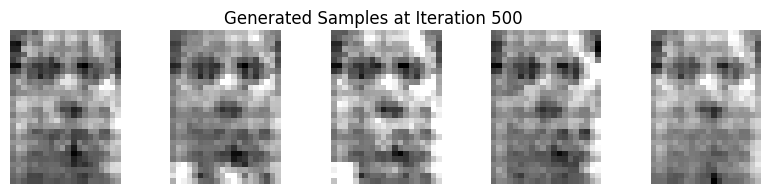

Iter 600/5000: Discriminator Loss: 0.1144, Generator Loss: 2.7600


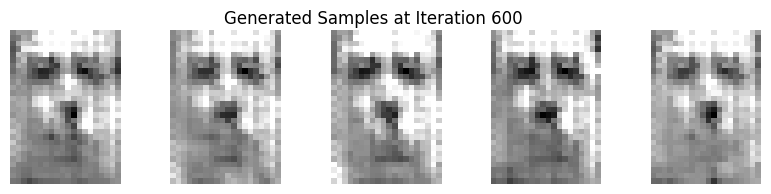

Iter 700/5000: Discriminator Loss: 0.1660, Generator Loss: 2.7597


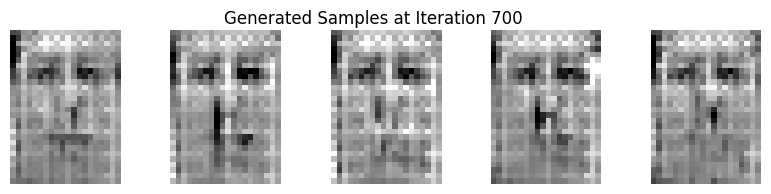

Iter 800/5000: Discriminator Loss: 0.5567, Generator Loss: 1.9987


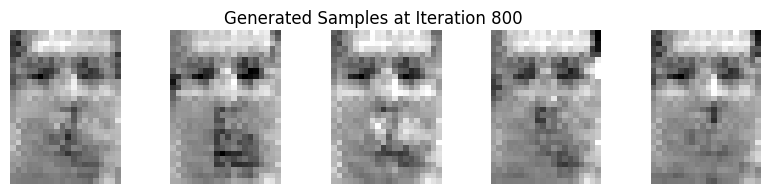

Iter 900/5000: Discriminator Loss: 0.1643, Generator Loss: 2.6550


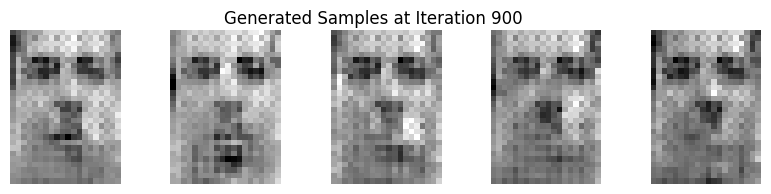

Iter 1000/5000: Discriminator Loss: 0.4199, Generator Loss: 1.6929


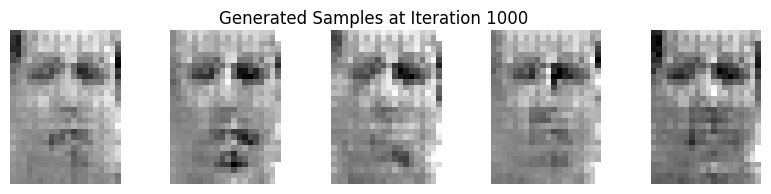

Iter 1100/5000: Discriminator Loss: 0.3716, Generator Loss: 2.8029


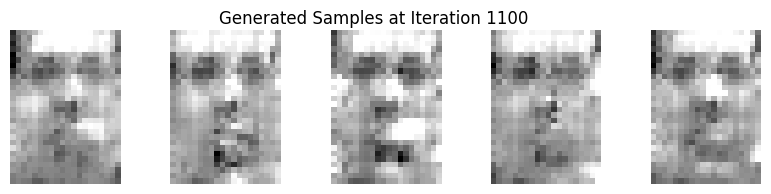

Iter 1200/5000: Discriminator Loss: 0.1720, Generator Loss: 3.5285


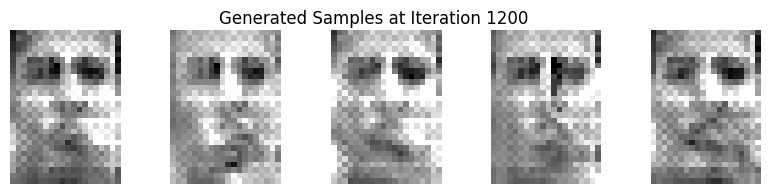

Iter 1300/5000: Discriminator Loss: 0.0851, Generator Loss: 2.4923


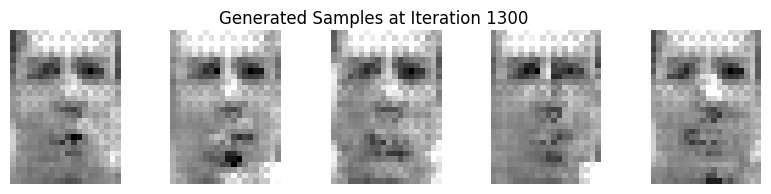

Iter 1400/5000: Discriminator Loss: 0.3047, Generator Loss: 2.3573


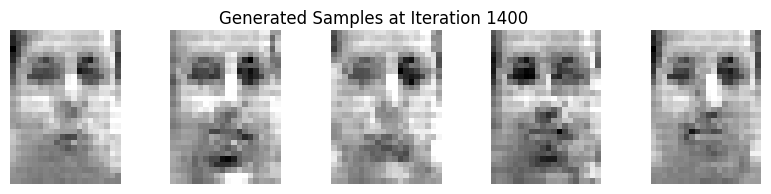

Iter 1500/5000: Discriminator Loss: 0.3001, Generator Loss: 1.9086


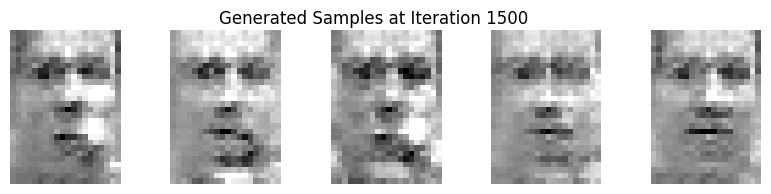

Iter 1600/5000: Discriminator Loss: 0.2996, Generator Loss: 2.3434


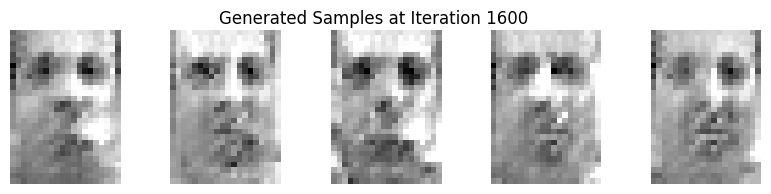

Iter 1700/5000: Discriminator Loss: 0.3061, Generator Loss: 1.5401


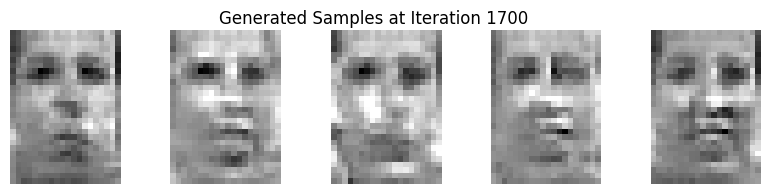

Iter 1800/5000: Discriminator Loss: 0.3759, Generator Loss: 1.8838


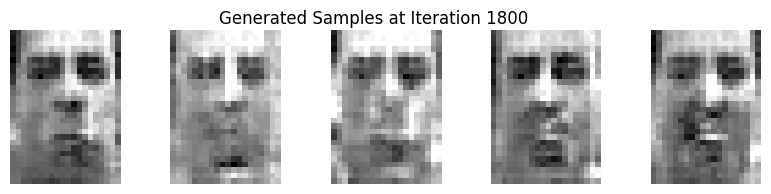

Iter 1900/5000: Discriminator Loss: 0.6511, Generator Loss: 1.4649


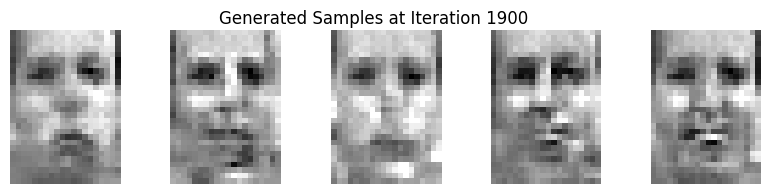

Iter 2000/5000: Discriminator Loss: 0.5141, Generator Loss: 1.3646


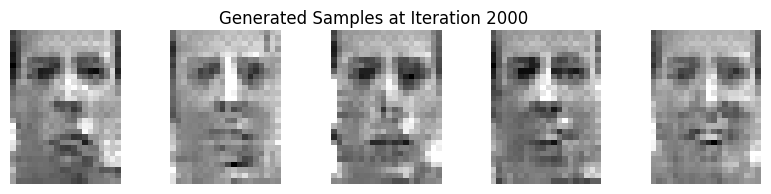

Iter 2100/5000: Discriminator Loss: 0.5378, Generator Loss: 1.3791


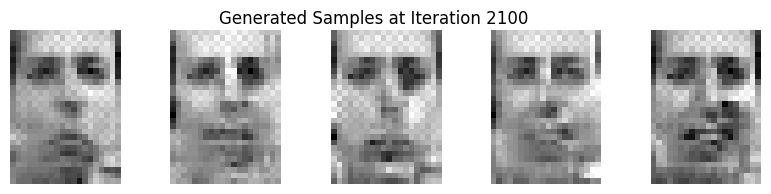

Iter 2200/5000: Discriminator Loss: 0.3810, Generator Loss: 1.9539


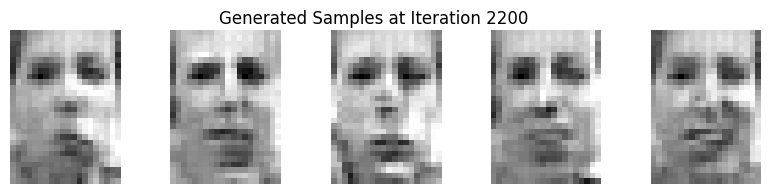

Iter 2300/5000: Discriminator Loss: 0.2054, Generator Loss: 2.6350


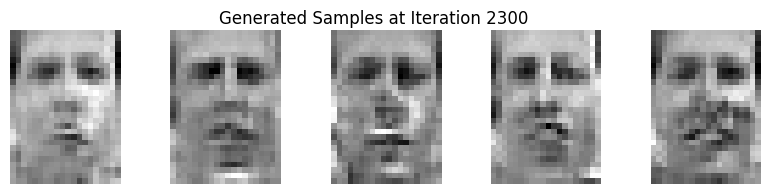

Iter 2400/5000: Discriminator Loss: 0.3712, Generator Loss: 1.9315


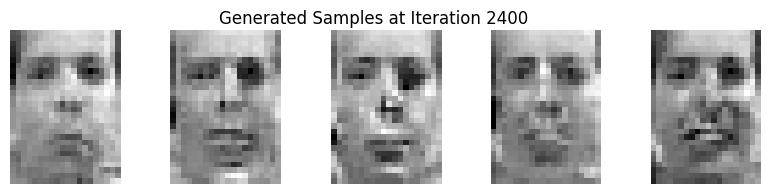

Iter 2500/5000: Discriminator Loss: 0.2560, Generator Loss: 2.2662


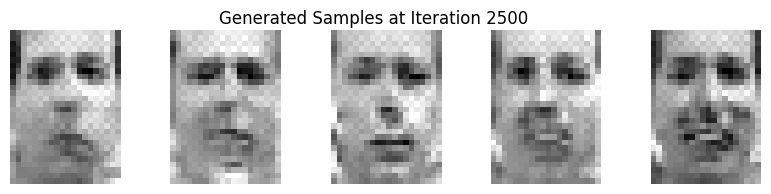

Iter 2600/5000: Discriminator Loss: 0.6336, Generator Loss: 0.9032


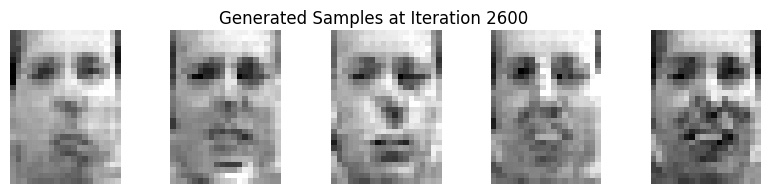

Iter 2700/5000: Discriminator Loss: 0.3086, Generator Loss: 1.8973


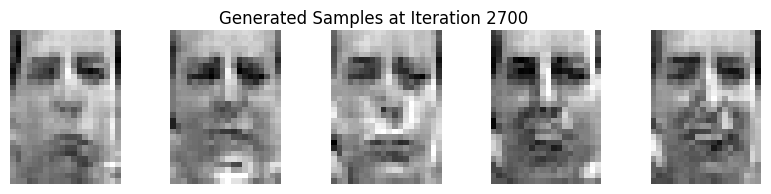

Iter 2800/5000: Discriminator Loss: 0.3708, Generator Loss: 1.7416


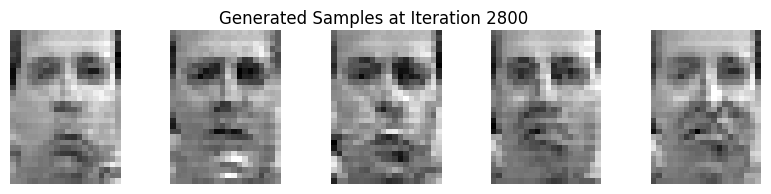

Iter 2900/5000: Discriminator Loss: 0.4955, Generator Loss: 1.0729


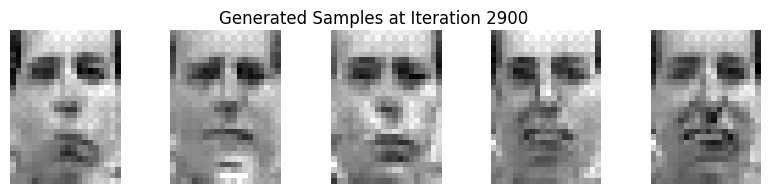

Iter 3000/5000: Discriminator Loss: 0.3682, Generator Loss: 1.8065


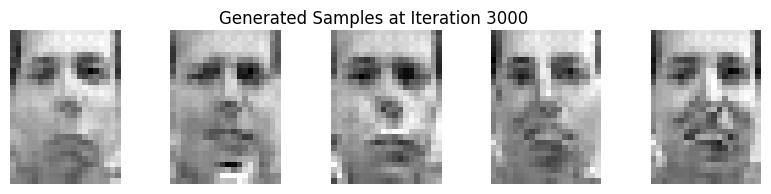

Iter 3100/5000: Discriminator Loss: 0.3530, Generator Loss: 1.6264


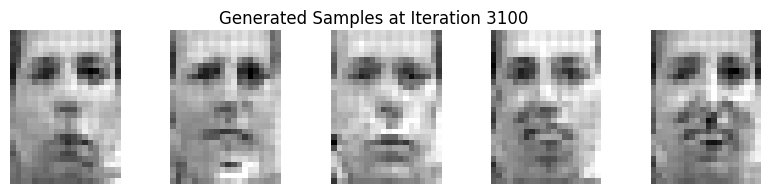

Iter 3200/5000: Discriminator Loss: 0.3580, Generator Loss: 1.9694


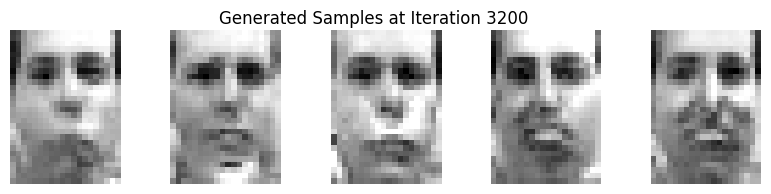

Iter 3300/5000: Discriminator Loss: 0.3776, Generator Loss: 1.8130


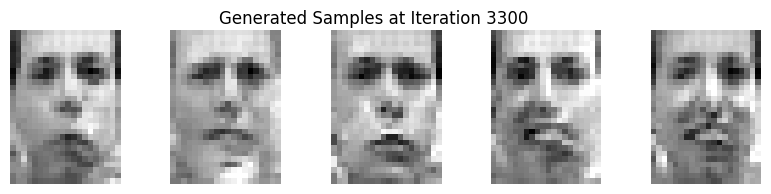

Iter 3400/5000: Discriminator Loss: 0.3357, Generator Loss: 1.5018


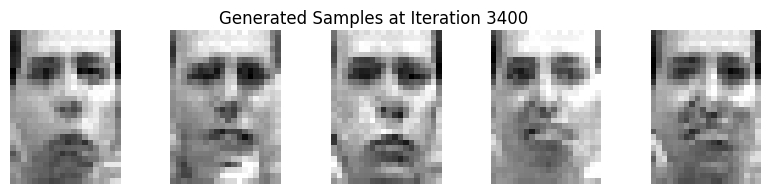

Iter 3500/5000: Discriminator Loss: 0.4590, Generator Loss: 1.8162


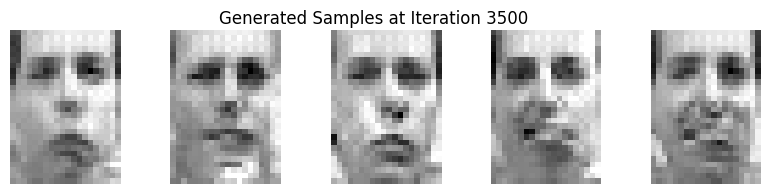

Iter 3600/5000: Discriminator Loss: 0.3390, Generator Loss: 1.5749


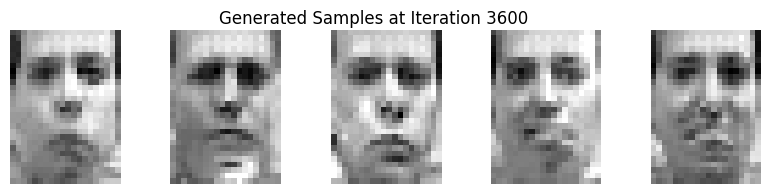

Iter 3700/5000: Discriminator Loss: 0.3566, Generator Loss: 1.5380


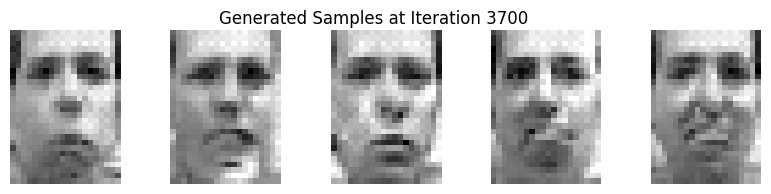

Iter 3800/5000: Discriminator Loss: 0.4490, Generator Loss: 1.5244


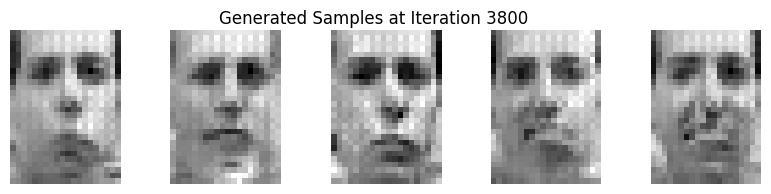

Iter 3900/5000: Discriminator Loss: 0.6376, Generator Loss: 0.8569


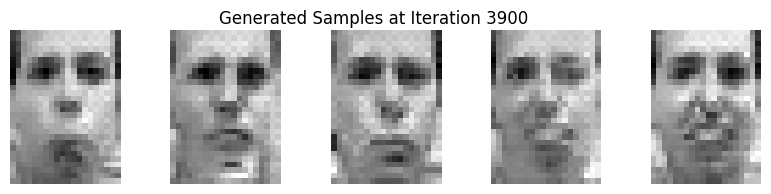

Iter 4000/5000: Discriminator Loss: 0.4119, Generator Loss: 1.4614


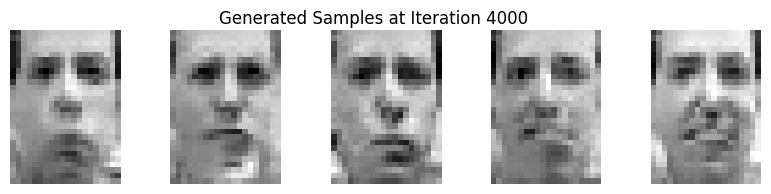

Iter 4100/5000: Discriminator Loss: 0.3323, Generator Loss: 1.7606


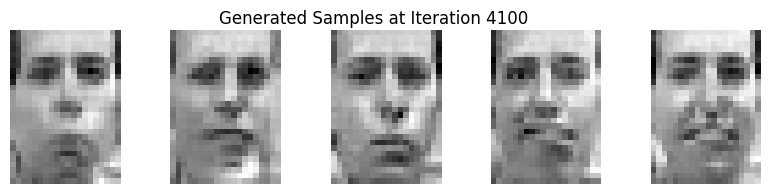

Iter 4200/5000: Discriminator Loss: 0.2488, Generator Loss: 2.0483


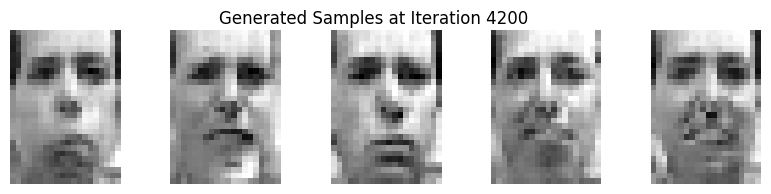

Iter 4300/5000: Discriminator Loss: 0.3263, Generator Loss: 1.7858


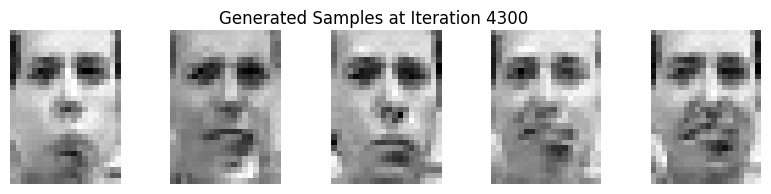

Iter 4400/5000: Discriminator Loss: 0.2302, Generator Loss: 1.9306


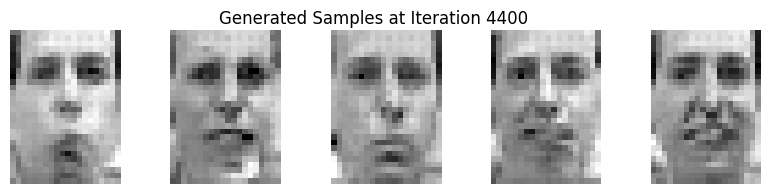

Iter 4500/5000: Discriminator Loss: 0.3287, Generator Loss: 1.7523


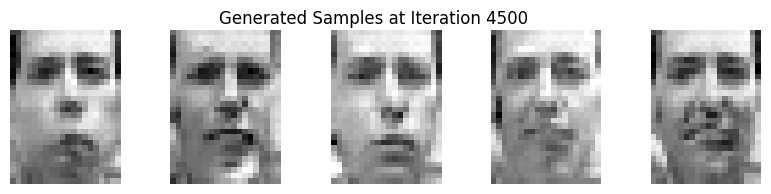

Iter 4600/5000: Discriminator Loss: 0.4176, Generator Loss: 1.6466


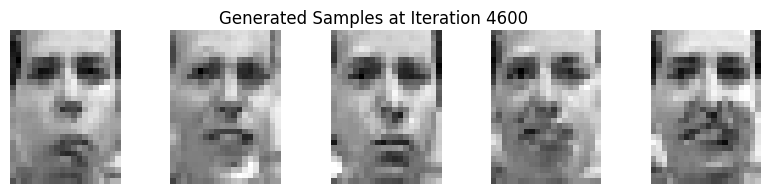

Iter 4700/5000: Discriminator Loss: 0.2173, Generator Loss: 1.6773


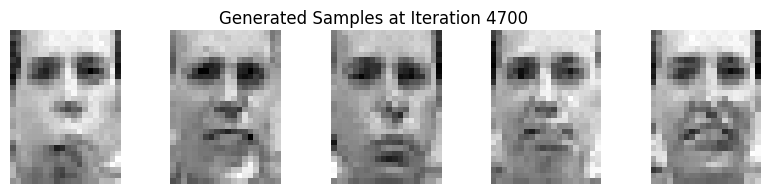

Iter 4800/5000: Discriminator Loss: 0.4271, Generator Loss: 1.5946


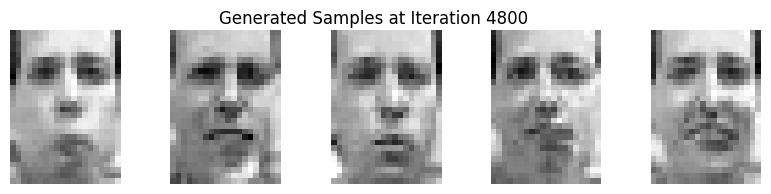

Iter 4900/5000: Discriminator Loss: 0.3639, Generator Loss: 1.8766


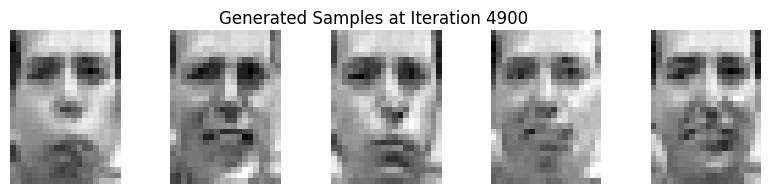

Iter 5000/5000: Discriminator Loss: 0.4942, Generator Loss: 1.1437


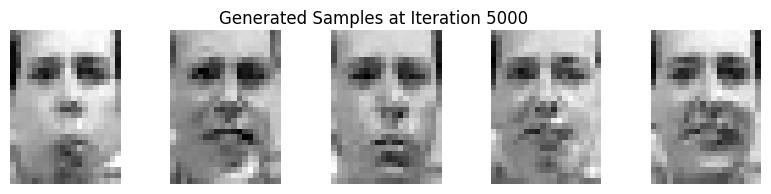


Training finished.


In [9]:
for iter_count in range(num_iter):
    # Select a random batch of real images
    inds = np.random.randint(0, x_train.shape[0], size=batch_size)
    x_real = x_train[inds]
    y_real = np.ones((batch_size, 1)) # Labels for real images: 1

    # Generate a batch of fake images
    random_latent_batch = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    x_fake = generator.predict(random_latent_batch, batch_size=batch_size, verbose=0)
    y_fake = np.zeros((batch_size, 1)) # Labels for fake images: 0

    # Discriminator loss
    with tf.GradientTape() as tape:
        pred_real = discriminator(x_real, training=True)
        real_loss = tf.reduce_mean(loss_fn(y_real, pred_real))

        pred_fake = discriminator(x_fake, training=True)
        fake_loss = tf.reduce_mean(loss_fn(y_fake, pred_fake))
        discrim_loss = 0.5 * (real_loss + fake_loss)

    # Compute gradients and update discriminator weights
    grads = tape.gradient(discrim_loss, discriminator.trainable_variables)
    d_opt.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Generate a new batch of latent vectors
    random_latent_batch_for_gen = np.random.uniform(-1, 1, size=(batch_size, latent_dim))
    # Target labels for generator: we want discriminator to think these are real (label 1)
    y_gen_target = np.ones((batch_size, 1))

    # Generator loss
    with tf.GradientTape() as tape:
        x_gen = generator(random_latent_batch_for_gen, training=True)
        # Discriminator's weights are frozen during generator update (handled by tape.gradient target)
        pred_gen_for_loss = discriminator(x_gen, training=False) # As per example, D is fixed here
        gen_loss = tf.reduce_mean(loss_fn(y_gen_target, pred_gen_for_loss))

    # Compute gradients and update generator weights
    grads = tape.gradient(gen_loss, generator.trainable_variables)
    g_opt.apply_gradients(zip(grads, generator.trainable_variables))

    # Log losses
    gen_loss_history.append(gen_loss.numpy())
    discrim_loss_history.append(discrim_loss.numpy())

    # Periodic summary output and generator sample visualization
    if (iter_count + 1) % 100 == 0:
        print('Iter %d/%d: Discriminator Loss: %.4f, Generator Loss: %.4f' % (
            iter_count + 1, num_iter, discrim_loss.numpy(), gen_loss.numpy()))

        x_gen_samples = generator.predict(latent_vectors_for_viz, verbose=0)

        plt.figure(figsize=(num_samples_to_show * 2, 2))
        for i in range(num_samples_to_show):
            plt.subplot(1, num_samples_to_show, i + 1)
            # De-normalize for display: from [-1, 1] to [0, 1]
            img_display = (np.squeeze(x_gen_samples[i]) + 1.0) / 2.0
            plt.imshow(np.clip(img_display, 0.0, 1.0)) # Clip to ensure valid range for imshow
            plt.axis('off')
        plt.suptitle(f'Generated Samples at Iteration {iter_count + 1}')
        plt.show()

print("\nTraining finished.")

### Plotting Loss Curves

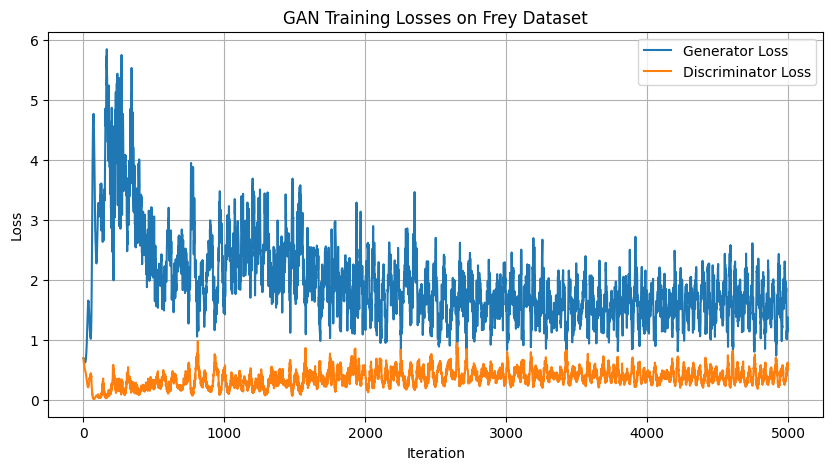

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(discrim_loss_history, label='Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('GAN Training Losses on Frey Dataset')
plt.legend()
plt.grid(True)
plt.show()

### Generating and Showing Final Images
Let's generate a batch of new images using the trained generator.


Generating some final samples...


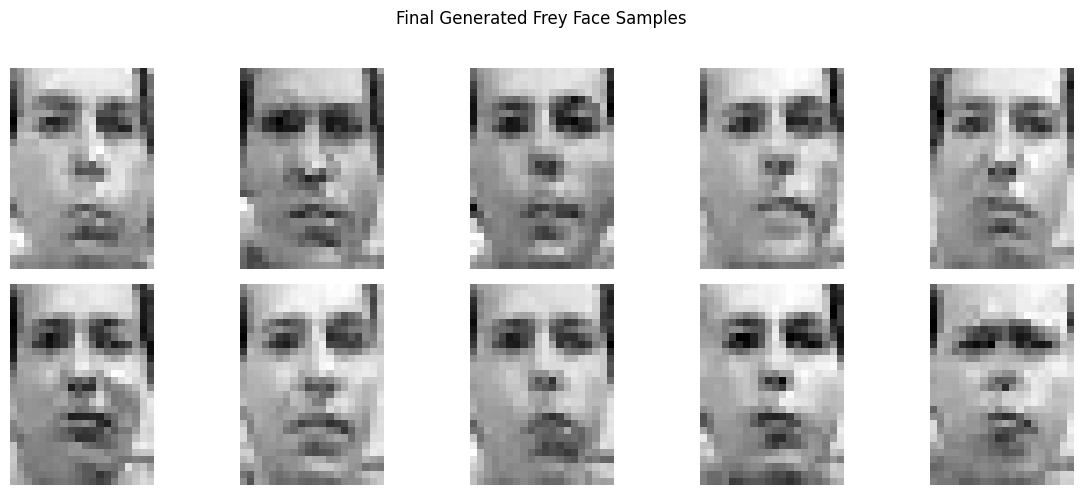

In [11]:
print("\nGenerating some final samples...")
num_final_samples = 10
# Ensure latent_dim is defined
final_latent_vectors = np.random.uniform(-1, 1, size=(num_final_samples, latent_dim))
final_samples = generator.predict(final_latent_vectors, verbose=0)

plt.figure(figsize=(12, 5)) # Adjusted for 2 rows of 5, or 1 row of 10
for i in range(num_final_samples):
    plt.subplot(2, 5, i + 1) # Assumes 10 samples to fit 2x5 grid
    img_display = (np.squeeze(final_samples[i]) + 1.0) / 2.0 # De-normalize
    plt.imshow(np.clip(img_display, 0.0, 1.0))
    plt.axis('off')
plt.suptitle('Final Generated Frey Face Samples')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to prevent suptitle overlap
plt.show()